# Distributed Training

## Prerequisites
This notebook was ran in databricks using the following configuration:

* Databricks Runtime Version: 14.3 LTS ML (Spark 3.5, GPU, Scala 2.12)
* Worker and executors instance type: g4dn.xlarge
* Cluster libraries:
  * neuralforecast==1.7.0
  * fugue
  * protobuf<=3.20.1
  * s3fs

## Load libraries

In [ ]:
import logging

import numpy as np
import pandas as pd

from neuralforecast import NeuralForecast, DistributedConfig
from neuralforecast.auto import AutoNHITS
from neuralforecast.models import NHITS, LSTM
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, rmse, smape
from utilsforecast.plotting import plot_series

2024-06-12 21:29:32.857491: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 21:29:32.901906: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 21:29:32.901946: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 21:29:32.901973: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 21:29:32.909956: I tensorflow/core/platform/cpu_feature_g

In [ ]:
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

## Data

In [ ]:
df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
df['exog_0'] = np.random.rand(df.shape[0])
static = df.groupby('unique_id').head(1).copy()
static['stat_0'] = static['unique_id'].astype('category').cat.codes
static = static[['unique_id', 'stat_0']]
valid = df.groupby('unique_id').tail(24)
train = df.drop(valid.index)
# save for loading in spark
s3_prefix = 's3://nixtla-tmp/distributed'
train.to_parquet(f'{s3_prefix}/train.parquet', index=False)
valid.to_parquet(f'{s3_prefix}/valid.parquet', index=False)
static.to_parquet(f'{s3_prefix}/static.parquet', index=False)
# load in spark
spark_train = spark.read.parquet(f'{s3_prefix}/train.parquet')
spark_valid = spark.read.parquet(f'{s3_prefix}/valid.parquet')
spark_static = spark.read.parquet(f'{s3_prefix}/static.parquet')

## Configuration

In [ ]:
# Configuration required for distributed training
dist_cfg = DistributedConfig(
    partitions_path=f'{s3_prefix}/partitions',  # path where the partitions will be saved
    num_nodes=2,  # number of nodes to use during training (machines)
    devices=1,   # number of GPUs in each machine
)

# pytorch lightning configuration
# the executors don't have permission to write on the filesystem, so we disable saving artifacts
distributed_kwargs = dict(
    accelerator='gpu',
    enable_progress_bar=False,
    logger=False,
    enable_checkpointing=False,
)

# exogenous features
exogs = {
    'futr_exog_list': ['exog_0'],
    'stat_exog_list': ['stat_0'],
}

# for the AutoNHITS
def config(trial):
    return dict(
        input_size=48,
        max_steps=2_000,
        learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        **exogs,
        **distributed_kwargs
    )

## Model training

In [ ]:
nf = NeuralForecast(
    models=[
        NHITS(h=24, input_size=48, max_steps=2_000, **exogs, **distributed_kwargs),
        AutoNHITS(h=24, config=config, backend='optuna', num_samples=2, alias='tuned_nhits'),
        LSTM(h=24, input_size=48, max_steps=2_000, **exogs, **distributed_kwargs),
    ],
    freq=1,
)
nf.fit(spark_train, static_df=spark_static, distributed_config=dist_cfg, val_size=24)

[rank: 0] Seed set to 1
/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
[rank: 0] Seed set to 1
INFO:TorchDistributor:Started distributed training with 2 executor processes
[rank: 1] Seed set to 1
[rank: 0] Seed set to 1
[rank: 1] Seed set to 1
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[rank: 0] Seed set to 1
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------

## Forecasting

When we're done training the model in a distributed way we can predict using the stored dataset. If we have future exogenous features we can provide a spark dataframe as `futr_df`. Note that if you want to load the stored dataset you need to provide the spark session through the `engine` argument.

In [ ]:
saved_ds_preds = nf.predict(futr_df=spark_valid.drop("y"), engine=spark).toPandas()

We can also provide a spark dataframe as `df` as well as `static_df` and `futr_df` (if applicable) to compute predictions on different data or after loading a saved model.

In [ ]:
new_df_preds = nf.predict(df=spark_train, static_df=spark_static, futr_df=spark_valid.drop("y")).toPandas()

Either of the above methods will yield the same results.

In [ ]:
pd.testing.assert_frame_equal(
    saved_ds_preds.sort_values(['unique_id', 'ds']).reset_index(drop=True),
    new_df_preds.sort_values(['unique_id', 'ds']).reset_index(drop=True),
    atol=1e-3,
)

## Saving for inference

We can now persist the trained models

In [ ]:
save_path = f'{s3_prefix}/model-artifacts'
nf.save(save_path, save_dataset=False, overwrite=True)

And load them back

In [ ]:
nf2 = NeuralForecast.load(save_path)

[rank: 0] Seed set to 1
[rank: 0] Seed set to 1
[rank: 0] Seed set to 1


We can now use this object to compute forecasts. We can provide either local dataframes (pandas, polars) as well as spark dataframes

In [ ]:
preds = nf.predict(df=train, static_df=static, futr_df=valid.drop(columns='y'))
preds2 = nf2.predict(df=train, static_df=static, futr_df=valid.drop(columns='y'))[preds.columns]
pd.testing.assert_frame_equal(saved_ds_preds, preds)
pd.testing.assert_frame_equal(preds, preds2)

## Evaluation

In [ ]:
(
    evaluate(
        preds.merge(valid.drop(columns='exog_0'), on=['unique_id', 'ds']),
        metrics=[mae, rmse, smape],
    )
    .drop(columns='unique_id')
    .groupby('metric')
    .mean()
)

,NHITS,tuned_nhits,LSTM
metric,,,
mae,417.075336,322.751522,270.423775
rmse,485.304941,410.998659,330.579283
smape,0.063995,0.066046,0.063975


## Plotting a sample

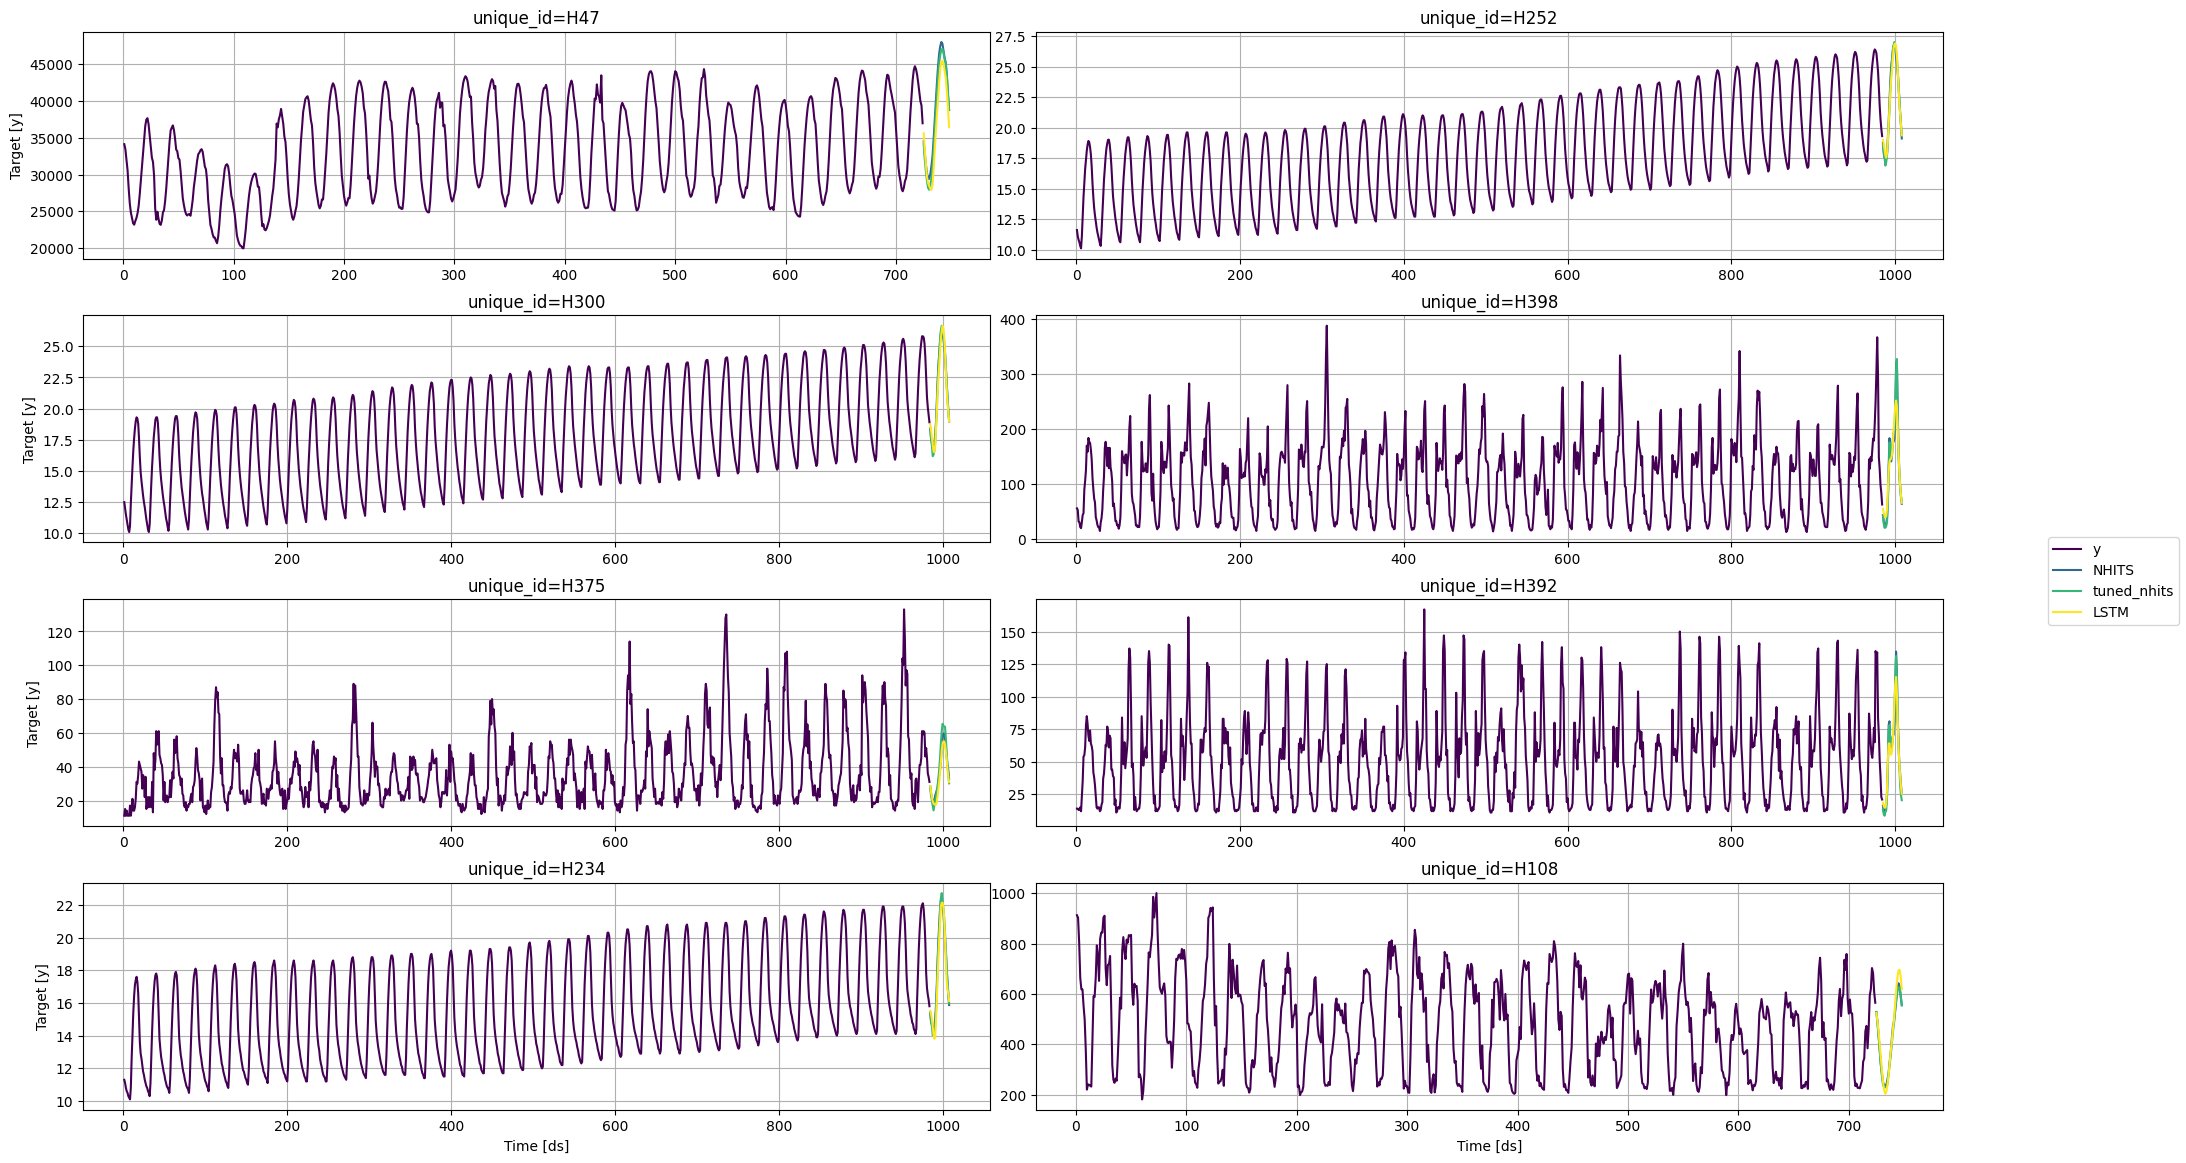

In [ ]:
plot_series(train, preds)